# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [8]:
import sys
from google.colab import drive
drive.mount('/content/drive')


BASE="/content/drive/My Drive/Colab Notebooks/TP_Final_CV"
sys.path.append(BASE)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!cd  "{BASE}"
!ls -ltr

total 8
drwxr-xr-x 1 root root 4096 Oct 28 16:30 sample_data
drwx------ 5 root root 4096 Nov  1 12:45 drive


In [10]:
# Imagen para estilo

!cd "{BASE}" &&  wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!cd "{BASE}" && wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir "{BASE}/output" 

--2020-11-01 19:04:28--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg.2’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.09s   

2020-11-01 19:04:28 (2.30 MB/s) - ‘La_noche_estrellada1.jpg.2’ saved [223725/223725]

--2020-11-01 19:04:28--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) 

In [11]:
# !ls -ltr "{BASE}"
# !cd "{BASE}" && rm "{BASE}/775*" 
!ls -ltr "{BASE}"

total 1325
-rw------- 1 root root 223725 Oct 10  2014 La_noche_estrellada1.jpg.2
-rw------- 1 root root 223725 Oct 10  2014 La_noche_estrellada1.jpg.1
-rw------- 1 root root 223725 Oct 10  2014 La_noche_estrellada1.jpg
-rw------- 1 root root 153015 May 25  2017 775px-Neckarfront_Tübingen_Mai_2017.jpg.2
-rw------- 1 root root 153015 May 25  2017 775px-Neckarfront_Tübingen_Mai_2017.jpg.1
-rw------- 1 root root 153015 May 25  2017 775px-Neckarfront_Tübingen_Mai_2017.jpg
-rw------- 1 root root  75966 Nov  1 17:12 andy_warhol_2.jpg
-rw------- 1 root root  57558 Nov  1 17:13 original_mia.jpg
-rw------- 1 root root  87963 Nov  1 18:43 picasso.jpg
drwx------ 2 root root   4096 Nov  1 18:56 output


In [12]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path

In [13]:
import tensorflow as tf
print(tf.__version__)
tf.compat.v1.disable_eager_execution()

2.3.0


In [66]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path(BASE + "/775px-Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path(BASE + "/La_noche_estrellada1.jpg")
result_prefix = Path(BASE + "/output")
iterations = 100

!ls "{base_image_path}"
!ls "{style_reference_image_path}"
!ls "{result_prefix}"

'/content/drive/My Drive/Colab Notebooks/TP_Final_CV/775px-Neckarfront_Tübingen_Mai_2017.jpg'
'/content/drive/My Drive/Colab Notebooks/TP_Final_CV/La_noche_estrellada1.jpg'
output_final_100_01.png        output_style01_content10.png
output_final_10_01.png	       output_style10_content1.png
output_final_10_1.png	       output_style1_content10.png
output_style01_content100.png  output_style5_content5.png


# Analisis de las imagenes a utilizar

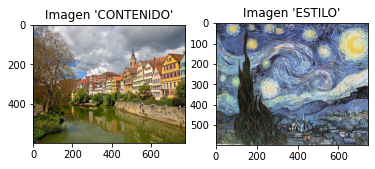

In [41]:
import matplotlib.pyplot as plt
from PIL import Image 
  
# Leo las imagenes del disco y las visualizo 
base_img = Image.open(base_image_path) 
style_img = Image.open(style_reference_image_path) 

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Imagen 'CONTENIDO'")
imgplot = ax1.imshow(base_img)
     
# ax2.title(style_reference_image_path)
ax2.set_title("Imagen 'ESTILO'")
imgplot = ax2.imshow(style_img)
plt.show()

In [16]:
width_c, height_c = base_img.size
print("Imagen contenido:", base_image_path)
print("Ancho:", width_c)
print("Alto:", height_c)

width_s, height_s = style_img.size
print("Imagen estilo:", style_reference_image_path)
print("Ancho:", width_c)
print("Alto:", height_c)

# Parecieran tener el mismo tamanio: OK

Imagen contenido: /content/drive/My Drive/Colab Notebooks/TP_Final_CV/original_mia.jpg
Ancho: 400
Alto: 517
Imagen estilo: /content/drive/My Drive/Colab Notebooks/TP_Final_CV/picasso.jpg
Ancho: 400
Alto: 517


# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:


**Respuesta:** El paper propone obtener una imagen final a partir de la combinacion de una imagen contenido (p) y una imagen de estilo (a). Esta combinacion se realizara partiendo de una imagen aleatoria (que en el paper llaman imagen de ruido blanco).

En el paper indican que tanto el contenido como el estilo se computan en cada layer de la CNN minimizando la distancia entre la imagen de ruido blanco con el contenido o estilo usando la formula de error estandard.

Se vera mas adelante que en el ejemplo de Keras se propone agregar a la formula que propone el paper una tercer elemento que ayuda a eliminar el ruido en el resultado final. El ***total_variation_weight*** es un factor de peso para dicha loss.

En la Loss Total $\alpha$ pondera el peso del contenido sobre el resultado final, mientras que $\beta$ pondera el peso del estilo.

Ej. 
$\mathit{L}_{total}(\vec{p},\vec{a},\vec{x}) = α  L_{contenido}(\vec{p},\vec{x}) + β L_{estilo}(\vec{a},\vec{x})$



In [17]:
total_variation_weight = 0.1
style_weight = 100
content_weight = 0.01

In [18]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:

1) La funcion Expand Dims tomara la imagen y le agrega una dimension (batch) que es la que necesita la VGG como tamanio de entrada.

2) La funcion Preprocess Input prepara la imagen para entrar a la VGG, segun la documentacion convierte la imagen de RGB a BGR y centra la imagenes segun el dataset de Imagenet sin re-escalarlas. --> Centrar la imagen es basicamente restarle la media (de las imagenes de imagenet)


In [19]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

### Pruebas

Ancho: 309
Alto: 517


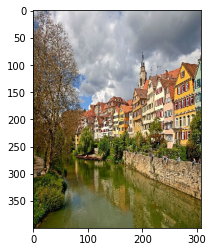

In [67]:
img = load_img(base_image_path, target_size=(img_nrows, img_ncols))
plt.imshow(img)
width, heigh = img.size
print("Ancho:", width)
print("Alto:", height)

In [68]:
img = img_to_array(img)
img.shape
# Alto, Ancho, Canales

(400, 309, 3)

In [69]:
img = np.expand_dims(img, axis=0)
img.shape
# batch, Ancho, Alto, Canales

(1, 400, 309, 3)

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

***Respuesta:***
Basicamente es la inversa del proceso realizado anteriormente. 

1) con el reshape quita la dimension de los batches quedandose con el W,H y canales RGB

2) Suma los valores de la media que antes resto. (imagino que esos valores los tomaron mirando el codigo de keras.

3) Revierte el BGR poniendo nuevamente a RGB

4) Pasa el array a enteros entre 0 y 255

In [23]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [24]:
!ls -l "{BASE}"

total 1325
-rw------- 1 root root 153015 May 25  2017 775px-Neckarfront_Tübingen_Mai_2017.jpg
-rw------- 1 root root 153015 May 25  2017 775px-Neckarfront_Tübingen_Mai_2017.jpg.1
-rw------- 1 root root 153015 May 25  2017 775px-Neckarfront_Tübingen_Mai_2017.jpg.2
-rw------- 1 root root  75966 Nov  1 17:12 andy_warhol_2.jpg
-rw------- 1 root root 223725 Oct 10  2014 La_noche_estrellada1.jpg
-rw------- 1 root root 223725 Oct 10  2014 La_noche_estrellada1.jpg.1
-rw------- 1 root root 223725 Oct 10  2014 La_noche_estrellada1.jpg.2
-rw------- 1 root root  57558 Nov  1 17:13 original_mia.jpg
drwx------ 2 root root   4096 Nov  1 18:56 output
-rw------- 1 root root  87963 Nov  1 18:43 picasso.jpg


In [25]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [26]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [27]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [28]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

***Respuesta:***

1) En álgebra lineal, la matriz de Gram de un conjunto de vectores v_1,$\dots$, v_n  es la matriz que define el producto escalar, cuyas entradas vienen dadas por $G_{ij}=(v_i|v_j)$. 

(fuente: https://en.wikipedia.org/wiki/Gramian_matrix)

**rta propia**: Se usa para determinar cuan similares son los vectores. 

2) Hay que permitar los vectores para permitir realizar el producto punto.

In [29]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:

## ****Style Loss****

Basicamente realiza el calculo explicado en el paper:

$ E_{l} = \frac{1}{4 * N_l^2 * M_l^2} * \sum_{ij} (G_{ij}^l - A_{ij}^l )^2$

donde

N: channels

M: size

G: es la gramm matrix de la imagen con el estilo

A: es la gram matrix de la imagen a ser generada (incialmente de ruido blanco)

Luego la loss final para el estilo sera:

$ L(\vec{a},\vec{x}) = 	\sum_{l=1}^{L} w_l * E_l $


## ****Content Loss****
Al igual que en style loss se aplica lo indicado en el paper:

$ L(\vec{p},\vec{x}) = 	\frac{1}{2} \sum_{ij} (F_{ij}^l - P_{ij}^l)^2 $

donde:

F: es la representacion de la imagen generada en la capa l luego de aplicar los filtros

P: es la imagen original

## ****Total Variation Loss****
Segun la documentacion de Keras: https://keras.io/examples/generative/neural_style_transfer/

Permite suavizar el ruido que se genera en la imagen resultante (combinada)

El paper muestra como resultado: 

$L_{total}(\vec{p},\vec{a},\vec{x}) = \alpha * L_{contenido}(\vec{p},\vec{x}) + \beta * L_{estilo}(\vec{a},\vec{x})$

En el paper de keras al agregar esta optimizacion quedaria algo como:

$L_{total}(\vec{p},\vec{a},\vec{x}) = \alpha * L_{contenido}(\vec{p},\vec{x}) + \beta * L_{estilo}(\vec{a},\vec{x}) + \gamma L_{total_variation}$


In [30]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [31]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [32]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [33]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [34]:
#tf.compat.v1.disable_eager_execution()
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:

La funcion **fmin_l_bfgs_b** del paquete scipy.optimize minimiza la loss durante las iteraciones utilizando el algoritmo L-BFGS-B (https://scipy.org/)

El paper como explique en la respuesta anterior no aplica la Total_Variation_Loss que segun el ejercicio de Keras ayuda a suavizar el resultado. 

El paper no explica que optimizador usar para minimizar las losses entiendo que eligieron ese paquete de scipy por que da buenos resultados, pero se podria probar con algun otro optimizador a ver que resultados da. 




In [35]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [36]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [37]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 521924020000.0
Image saved as /content/drive/My Drive/Colab Notebooks/TP_Final_CV/output/output_at_iteration_0.png
Iteration 0 completed in 7s
Start of iteration 1
Current loss value: 262508890000.0
Image saved as /content/drive/My Drive/Colab Notebooks/TP_Final_CV/output/output_at_iteration_1.png
Iteration 1 completed in 4s
Start of iteration 2
Current loss value: 194668560000.0
Image saved as /content/drive/My Drive/Colab Notebooks/TP_Final_CV/output/output_at_iteration_2.png
Iteration 2 completed in 4s
Start of iteration 3
Current loss value: 155419100000.0
Image saved as /content/drive/My Drive/Colab Notebooks/TP_Final_CV/output/output_at_iteration_3.png
Iteration 3 completed in 4s
Start of iteration 4
Current loss value: 128886620000.0
Image saved as /content/drive/My Drive/Colab Notebooks/TP_Final_CV/output/output_at_iteration_4.png
Iteration 4 completed in 4s
Start of iteration 5
Current loss value: 110376060000.0
Image saved as /content/

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:

In [60]:
original_path=Path(BASE + "/output/output_style10_content1.png")
more_content_than_style=Path(BASE + "/output/output_style1_content10.png")
exagerated_content_than_style=Path(BASE + "/output/output_style01_content100.png")

img_1 = Image.open(original_path)
img_2 = Image.open(more_content_than_style)
img_3 = Image.open(exagerated_content_than_style)

### Imagen Original (Estilo 10, Contenido 1)

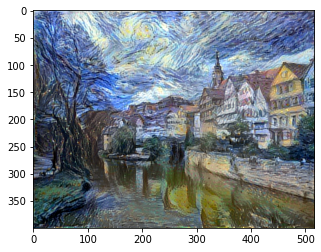

In [61]:
plt.imshow(img_1)

### Invierto (Estilo 1, Contenido 10)

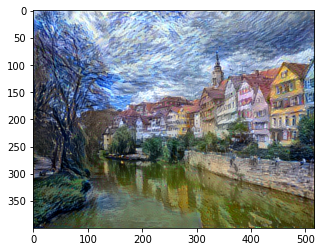

In [62]:
plt.imshow(img_2)

### Exagero la cantidad de contenido por sobre el estilo (Style:0,1, Contenido:100)

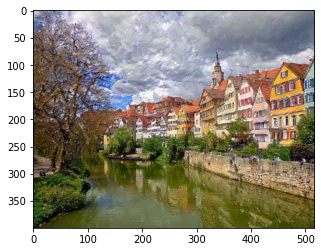

In [64]:
plt.imshow(img_3)

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:

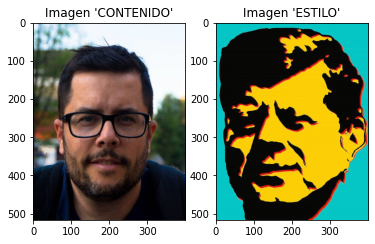

In [48]:

base_image_path = Path(BASE + "/original_mia.jpg")
style_reference_image_path = Path(BASE + "/andy_warhol_2.jpg")
result_path= Path(BASE + "/output/output_final_10_01.png")

# Leo las imagenes del disco y las visualizo 
base_img = Image.open(base_image_path) 
style_img = Image.open(style_reference_image_path) 

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Imagen 'CONTENIDO'")
imgplot = ax1.imshow(base_img)
     
# ax2.title(style_reference_image_path)
ax2.set_title("Imagen 'ESTILO'")
imgplot = ax2.imshow(style_img)
plt.show()

# Resultado

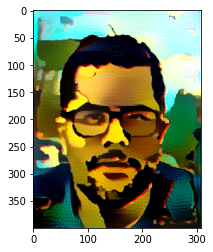

In [51]:
resultado=Image.open(result_path) 
plt.imshow(resultado)